In [24]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm

In [3]:
%%cython -+ 
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable
    
cdef void init_spins(long[::1] spins, RndmWrapper rndm): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js, RndmWrapper rndm): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2):
    
    for i in range(L1*L2):
        Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
        Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
        Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
        Js[i, (i + L2) % (L1*L2)] = J
        Js[i, (i // L2) * L2 + (i - 1) % L2] = J
        Js[i, (i - L2) % (L1*L2)] = J
    return
        

def simulate(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps, int a_time, int seed, int rseed = 1234):


    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        int num_therm = int(20*L)
        int steps_per_sweep = L * L 
        int sweep = 0
        int i
        double Z = 0.
        enes = []
        
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed)) 
    cdef RealObservable ene = RealObservable()

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins, rndm)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
            
    for sweep in range(num_sweeps):
        for i in range(a_time * steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
            
        Z += 1
        enes.append(energy(spins, neighbors, Js))
        #ene.add_measurement(energy(spins, neighbors, Js))
     
    return enes

In [4]:
# корни из уравнения в другом файле
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds,roots))

In [5]:
Jd = -0.3
round(get_crit_T[Jd],3)

1.749

In [38]:
L = 10
T = 2.1
n_sweeps = 10000
a_time = 1

energies = simulate(L,T,1,0,n_sweeps,a_time,random.randint(0,1000))

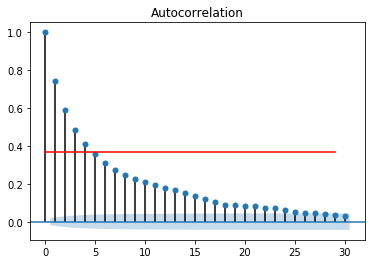

In [39]:
l = 30
plot_acf(energies, lags = l)
plt.plot([1/np.e] * l, c = 'r')
plt.show()

In [110]:
ACF = acf(energies, nlags = l, fft = False)

In [65]:
for i,a in enumerate(ACF):
    if a <= 1/np.e:
        print("MCS number = " ,i, "; Temp = ", T)
        break

MCS number =  5 ; Temp =  2.1


In [ ]:
# по аналогии вычисляю время для интервала температур

In [13]:
L = 40
Ts = np.arange(0.05, 7, 0.05)
MCS = np.ones(len(Ts))
n_sweeps = 10000
a_time = 1
l = 80

for j,t in enumerate(Ts):
    energies = simulate(L,t,1,0,n_sweeps,a_time,random.randint(0,1000))
    ACF = acf(energies, nlags = l, fft = False)
    MCS[j] = l
    for i,a in enumerate(ACF):
        if a <= 1/np.e:
            MCS[j] = i
            break

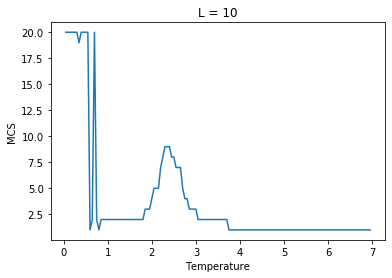

In [10]:
plt.plot(Ts, MCS) 
plt.title(f'L = {L}')
plt.xlabel('Temperature')
plt.ylabel('MCS')
plt.show()

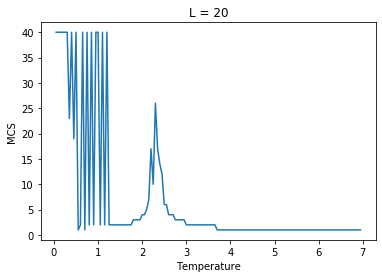

In [12]:
plt.plot(Ts, MCS) 
plt.title(f'L = {L}')
plt.xlabel('Temperature')
plt.ylabel('MCS')
plt.show()

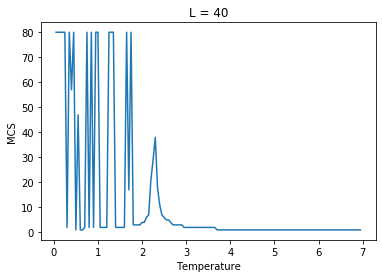

In [14]:
plt.plot(Ts, MCS) 
plt.title(f'L = {L}')
plt.xlabel('Temperature')
plt.ylabel('MCS')
plt.show()

In [ ]:
# посмотрим акф в крит точках для разных длин

In [267]:
L = 40
Jd = 0
n_sweeps = 1000000
T = get_crit_T[Jd]
a_time = 1


energies = simulate(L,T,1,Jd,n_sweeps,a_time,random.randint(0,1000))

In [268]:
l = 1000
ACF = acf(energies, nlags = l, fft = False)

In [274]:
lnA = -0.99
tau = 300

x = [0,l]
y = [ lnA - i/tau for i in x]

a = np.exp(lnA)
print(a)

0.3715766910220457


Text(0.5, 0.98, 'L = 40, tau = 300, a = 0.372, Jd = 0')

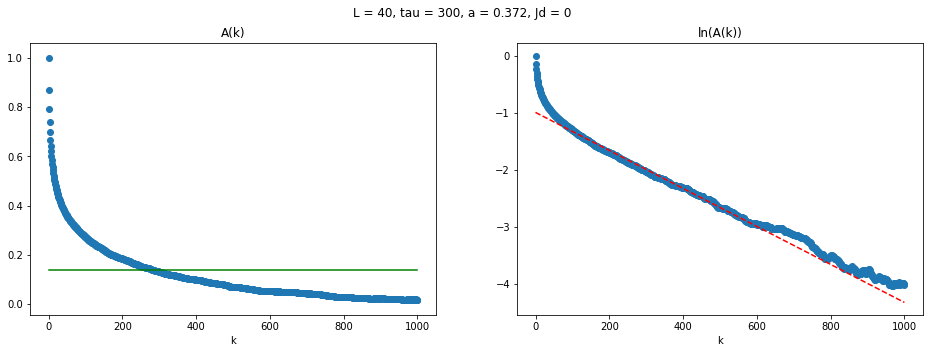

In [275]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'L = {L}, tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 1 000 000

Text(0.5, 0.98, 'L = 40, tau = 120, a = 0.472, Jd = 0')

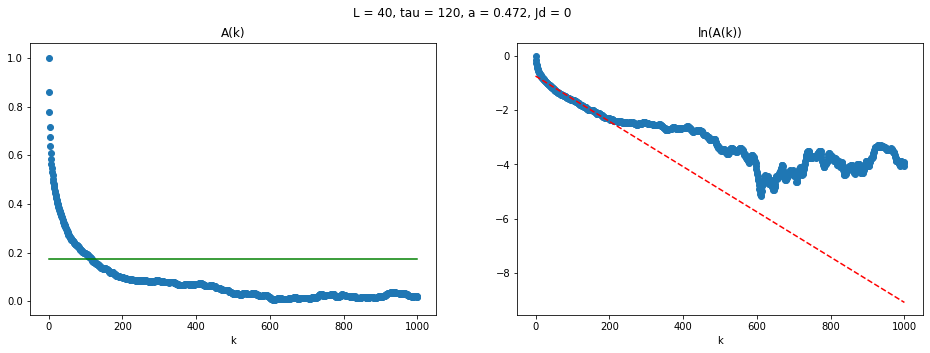

In [266]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'L = {L}, tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 100 000

Text(0.5, 0.98, 'L = 40, tau = 320, a = 0.427, Jd = -0.3')

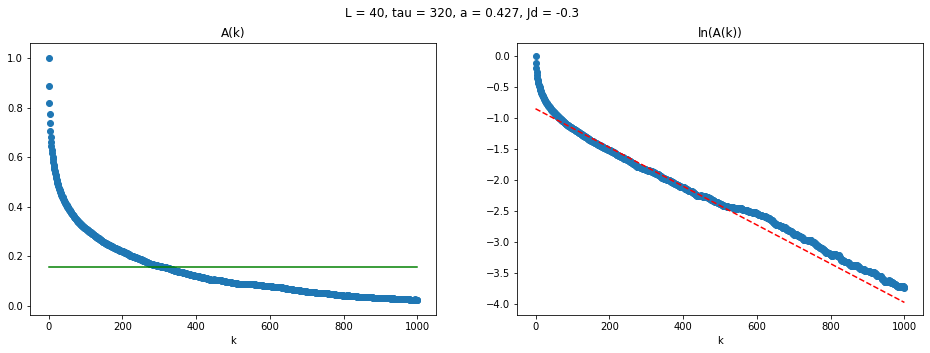

In [260]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'L = {L}, tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 1 000 000

/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


Text(0.5, 0.98, 'L = 40, tau = 170, a = 0.522, Jd = -0.3')

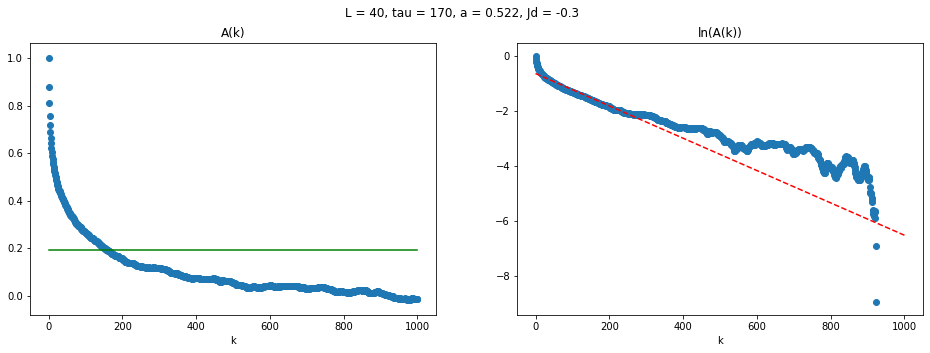

In [242]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'L = {L}, tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 100 000

Text(0.5, 0.98, 'L = 40, tau = 2500, a = 0.549, Jd = -0.7')

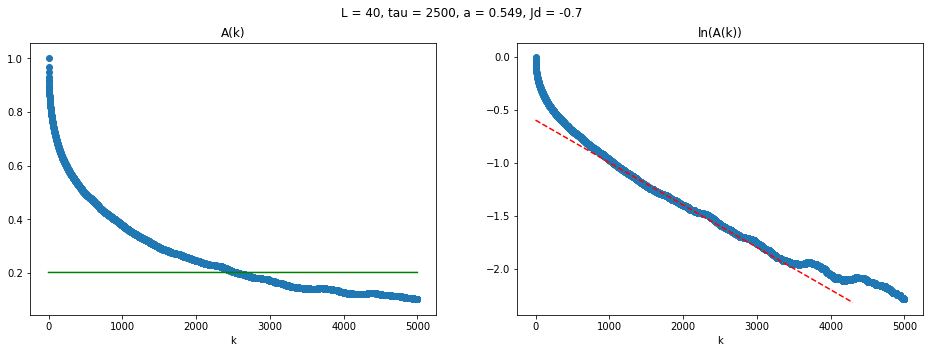

In [228]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'L = {L}, tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 1 000 000

Text(0.5, 0.98, 'L = 40, tau = 2100, a = 0.705, Jd = -0.7')

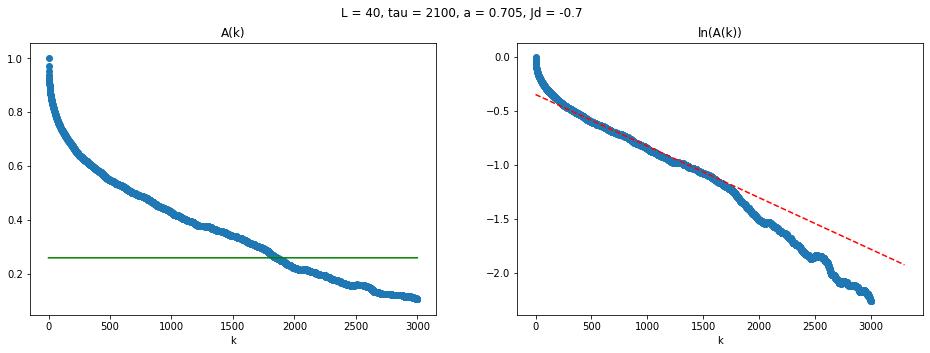

In [216]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'L = {L}, tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 100 000

Text(0.5, 0.98, 'tau = 140, a = 0.607, Jd = -0.7')

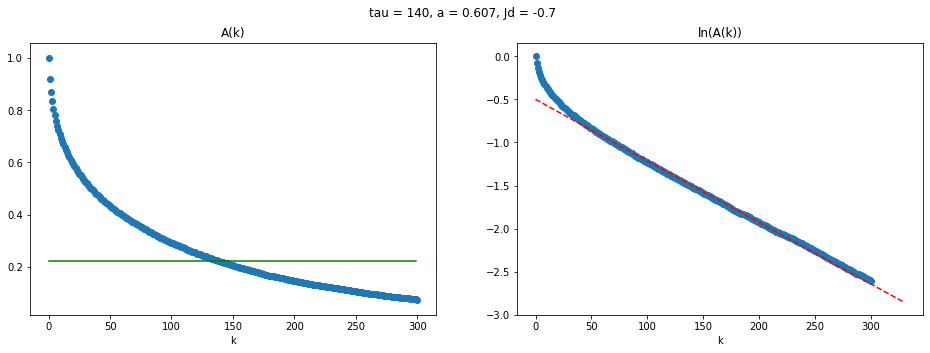

In [154]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 1 000 000

Text(0.5, 0.98, 'tau = 130, a = 0.638, Jd = -0.7')

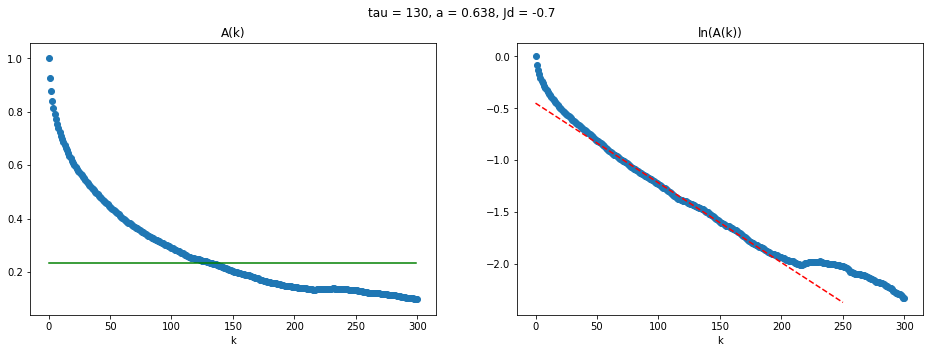

In [129]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 100 000

Text(0.5, 0.98, 'tau = 60, a = 0.638, Jd = -0.7')

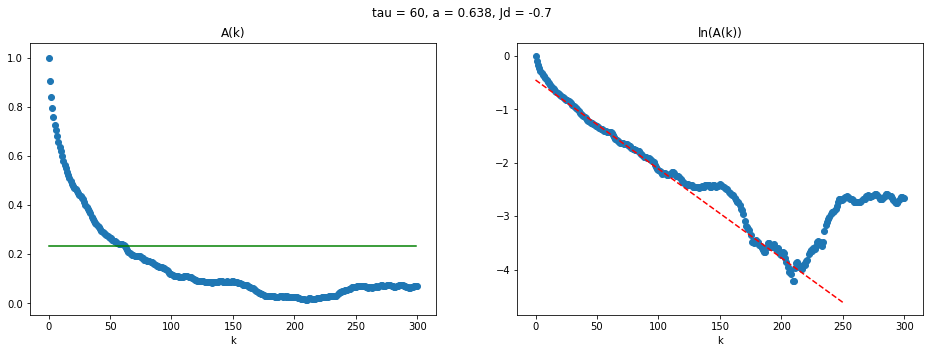

In [141]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 10 000

/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


Text(0.5, 0.98, 'tau = 24, a = 0.549, Jd = -0.3')

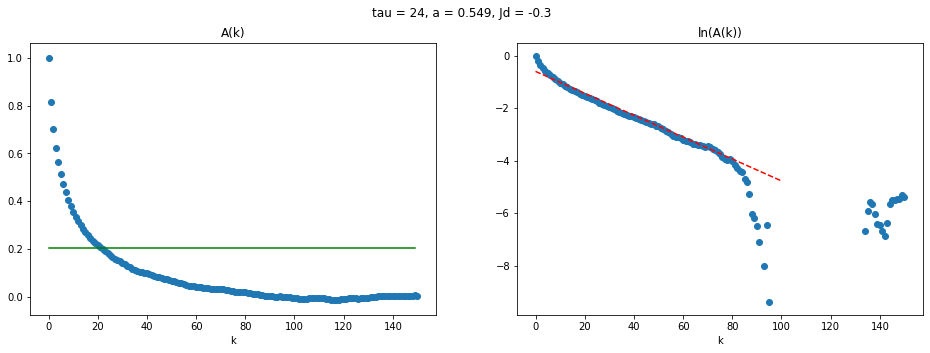

In [91]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 100 000

Text(0.5, 0.98, 'tau = 23, a = 0.607, Jd = -0.3')

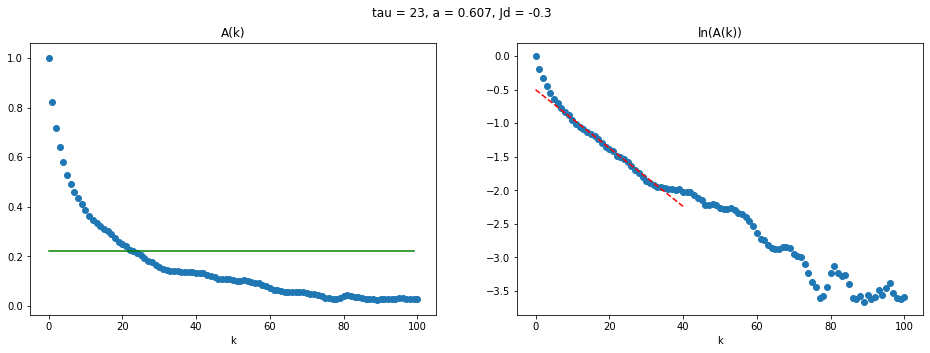

In [77]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 10 000

Text(0.5, 0.98, 'tau = 17, a = 0.497, Jd = 0')

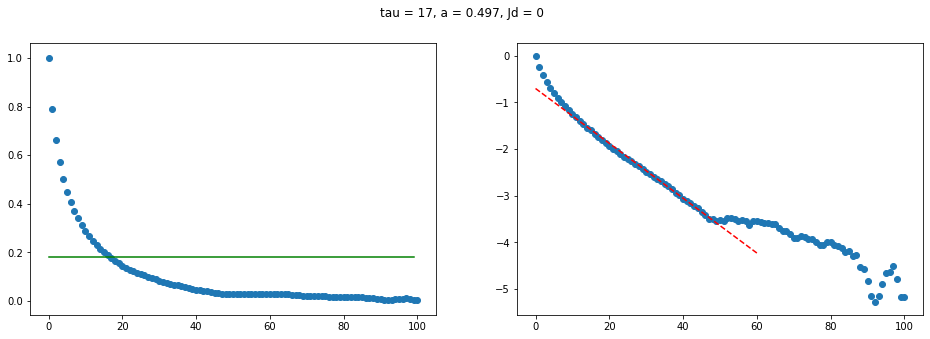

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.plot([a/np.e] * l, c = 'g')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 100 000 

Text(0.5, 0.98, 'tau = 10, a = 0.705, Jd = 0')

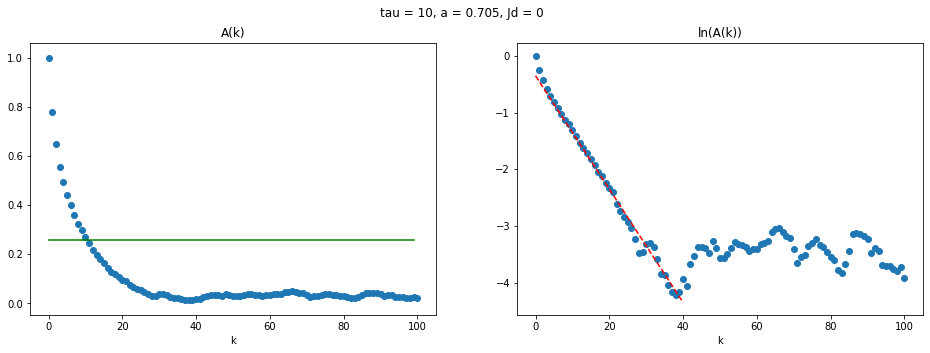

In [57]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,5))
ax1.scatter(np.arange(0,l+1,1),ACF)
ax1.set_title('A(k)')
ax1.set_xlabel('k')
ax1.plot([a/np.e] * l, c = 'g')

ax2.set_xlabel('k')
ax2.set_title('ln(A(k))')
ax2.scatter(np.arange(0,l+1,1), np.log(ACF))
ax2.plot(x,y,c='r',linestyle = '--')
fig.suptitle(f'tau = {tau}, a = {a:.3}, Jd = {Jd}')
#для 10 000

In [20]:
%%time
L = 80
l = 400
Jd = -0.4

n_sweeps = 100000
N = 1

T_crit = round(get_crit_T[Jd],3)
Ts = np.arange(T_crit - 0.1, T_crit + 0.2, 0.05) # отступаю 0.1 от критической
MCS_mean = np.ones(len(Ts))
MCS_max = np.ones(len(Ts))
error = np.ones(len(Ts))
a_time = 1
MCSs = np.zeros((N,len(Ts)))

for jj in range(N):
    for j,t in enumerate(Ts):
        energies = simulate(L,t,1,Jd,n_sweeps,a_time,random.randint(0,1000))
        ACF = acf(energies, nlags = l, fft = False)
        MCSs[jj,j] = l
        for i,a in enumerate(ACF):
            if a <= 1/np.e:
                MCSs[jj,j] = i
                break
                
error = np.ones(len(Ts))
for i in range(len(Ts)):
    MCS_max[i] = np.max([MCSs[_,i] for _ in range(N)])
    MCS_mean[i] = np.mean([MCSs[_,i] for _ in range(N)])
    error[i] = np.std([MCSs[_,i] for _ in range(N)])
    

Ts_tail = np.arange(T_crit + 0.1, 5 ,0.1) # хвост (одно измерение)
MCS_tail = np.ones(len(Ts_tail))

for j,t in enumerate(Ts_tail):
    energies = simulate(L,t,1,Jd,n_sweeps,a_time,random.randint(0,1000))
    ACF = acf(energies, nlags = l, fft = False)
    MCS_tail[j] = l
    for i,a in enumerate(ACF):
        if a <= 1/np.e:
            MCS_tail[j] = i
            break

CPU times: user 1h 4min 57s, sys: 1min 5s, total: 1h 6min 2s
Wall time: 1h 29s


In [ ]:
times = []
J_d = -0.4
for j in range(5):
    energies = simulate(80,round(get_crit_T[Jd],3),1,Jd,100000,1,random.randint(0,1000))
    ACF = acf(energies, nlags = 500, fft = False)
    for i,a in enumerate(ACF):
        if a <= 1/np.e:
            times.append(i)
            break

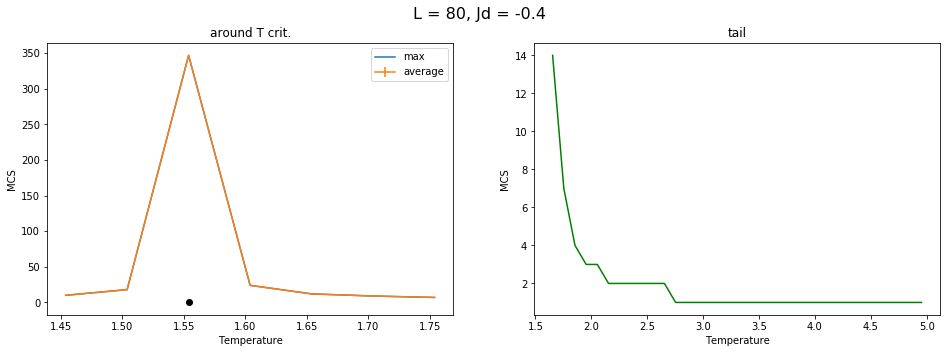

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))

ax1.scatter([T_crit], [0], c  = 'black')
ax1.plot(Ts, MCS_max, label = 'max') 
ax1.errorbar(Ts, MCS_mean, yerr = error, label = 'average') 
ax1.set_title('around T crit.')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('MCS')
ax1.legend()

ax2.plot(Ts_tail, MCS_tail, c = 'g') 
ax2.set_title('tail')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('MCS')

fig.suptitle(f'L = {L}, Jd = {Jd}', fontsize=16)
plt.show()

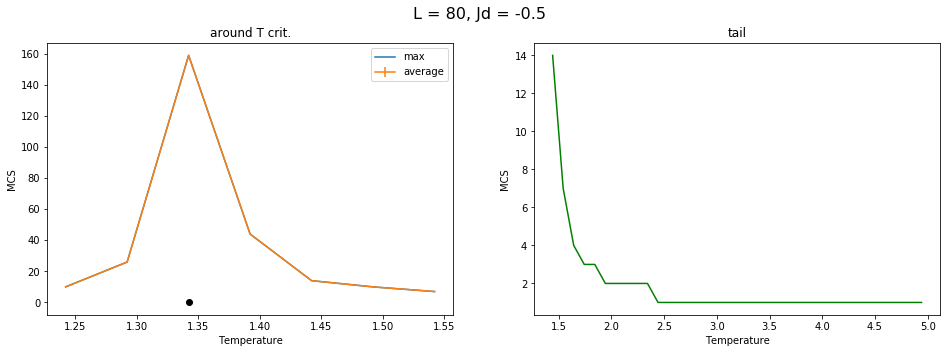

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))

ax1.scatter([T_crit], [0], c  = 'black')
ax1.plot(Ts, MCS_max, label = 'max') 
ax1.errorbar(Ts, MCS_mean, yerr = error, label = 'average') 
ax1.set_title('around T crit.')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('MCS')
ax1.legend()

ax2.plot(Ts_tail, MCS_tail, c = 'g') 
ax2.set_title('tail')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('MCS')

fig.suptitle(f'L = {L}, Jd = {Jd}', fontsize=16)
plt.show()

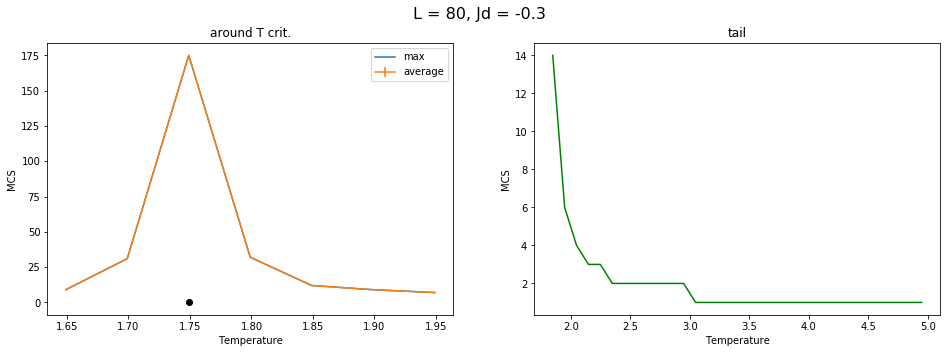

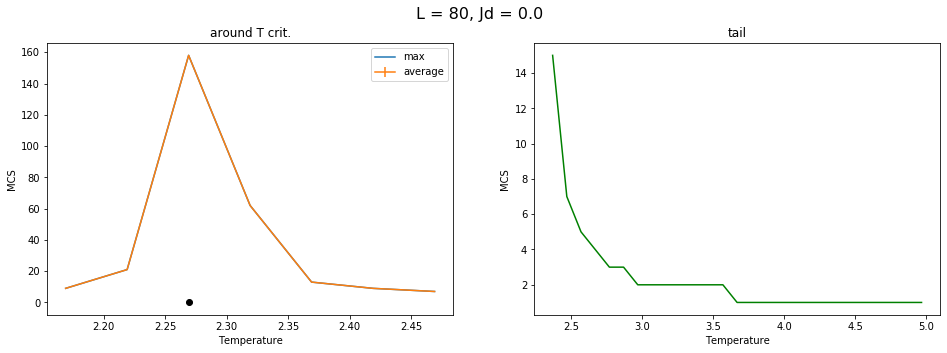

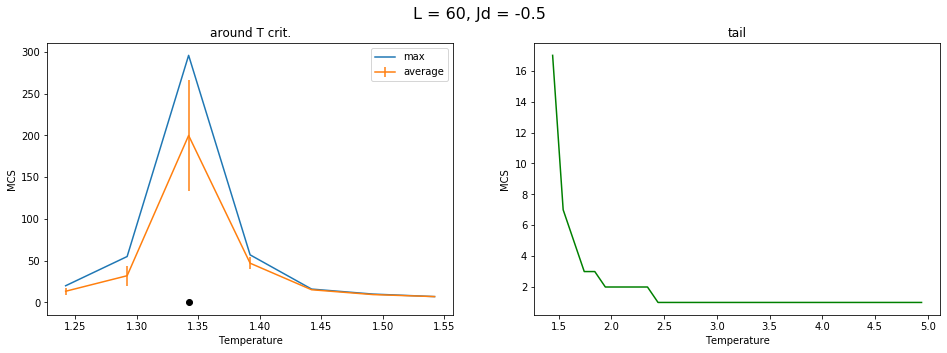

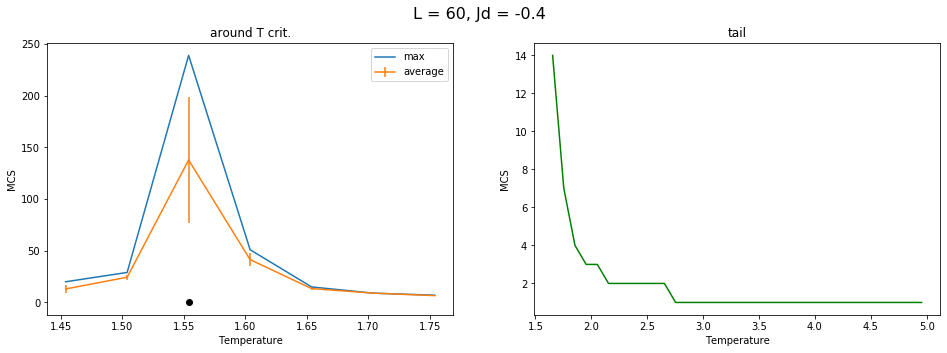

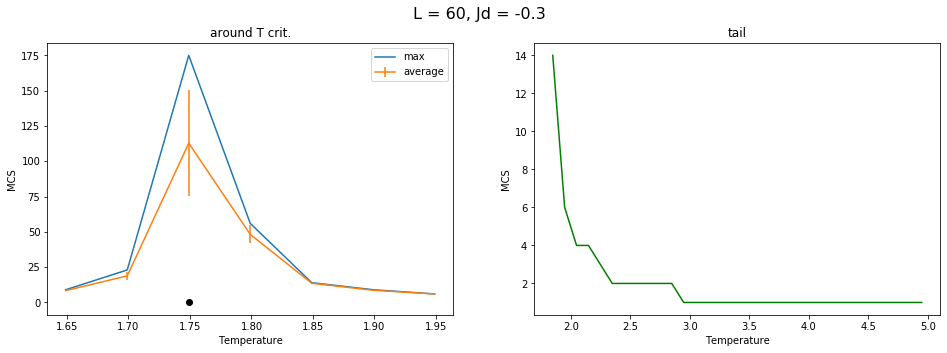

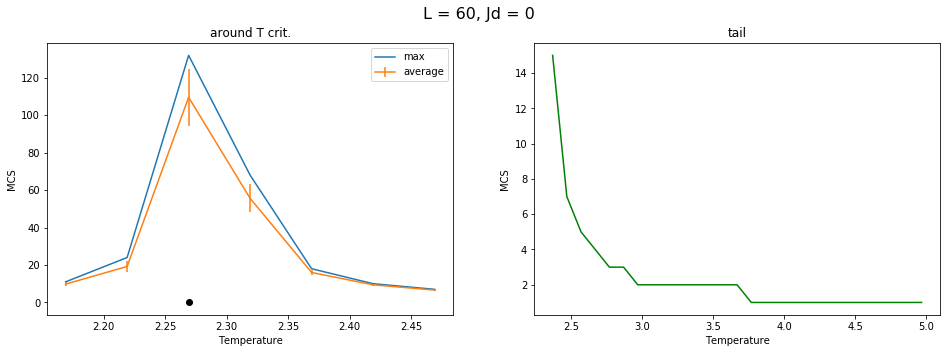

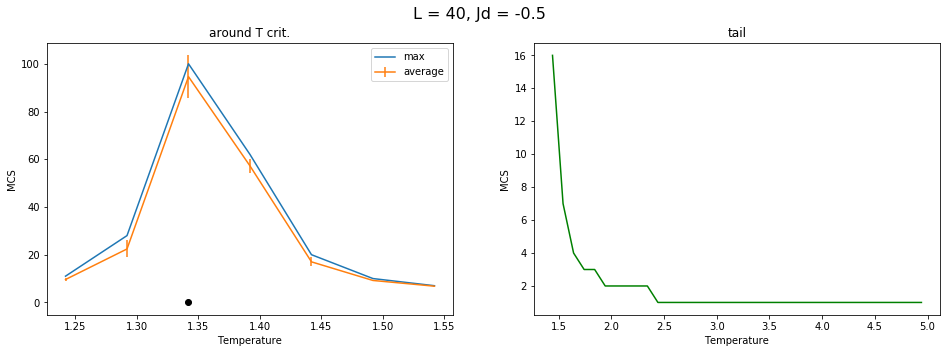

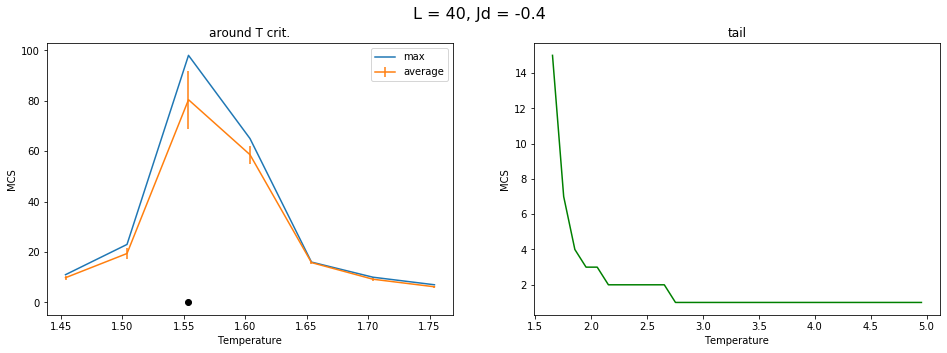

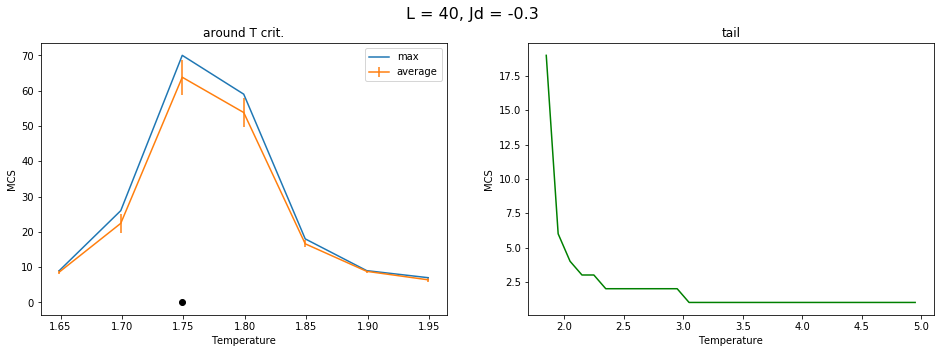

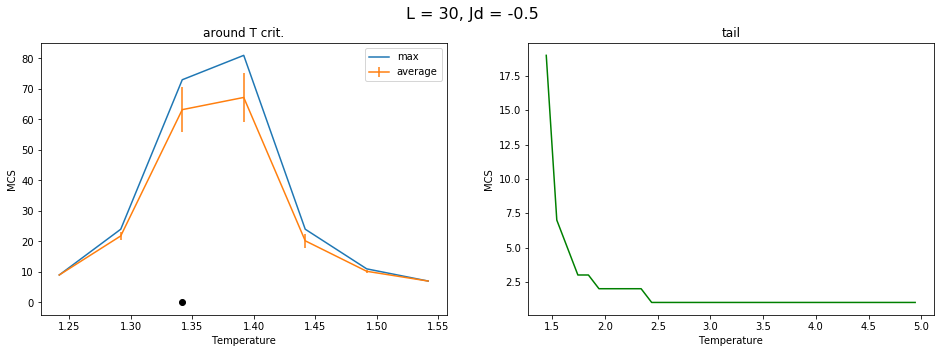

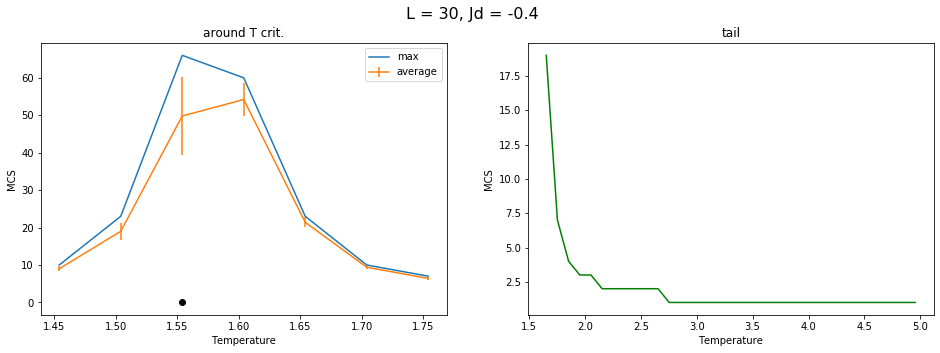

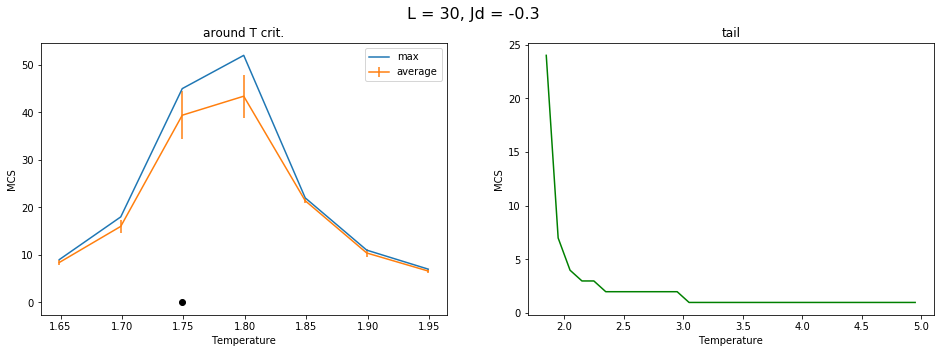

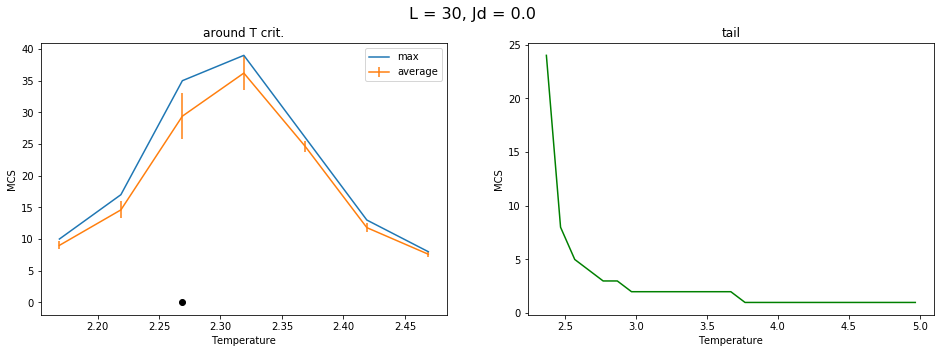

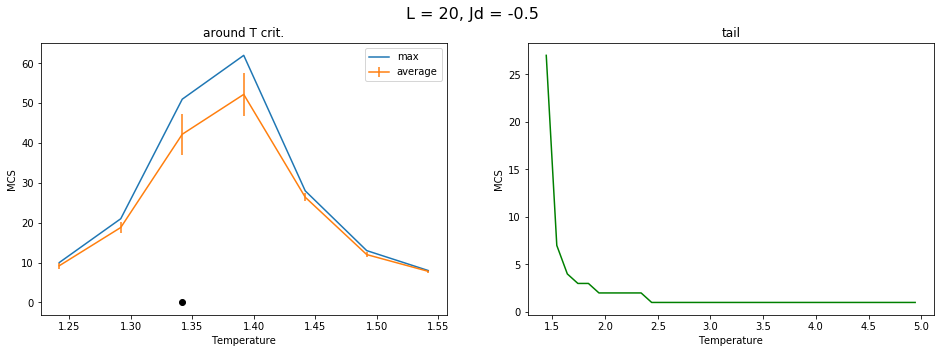

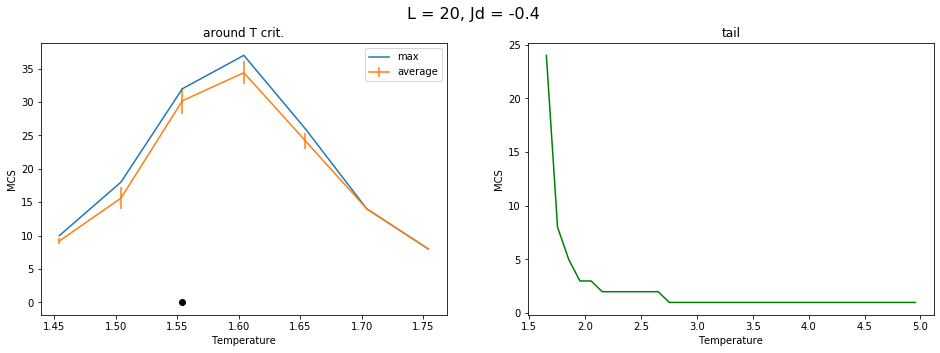

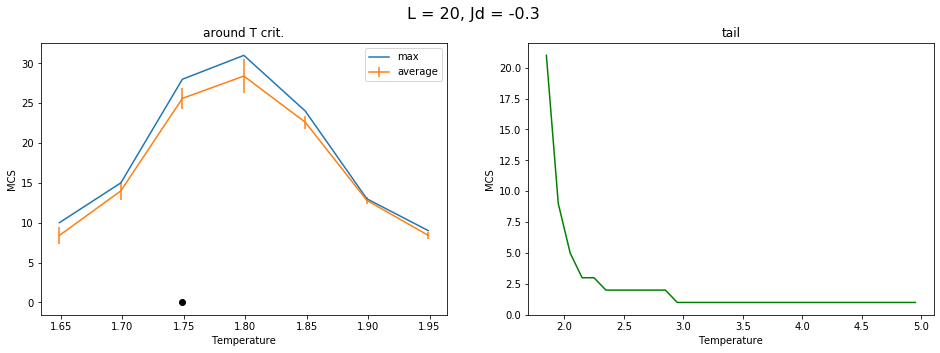

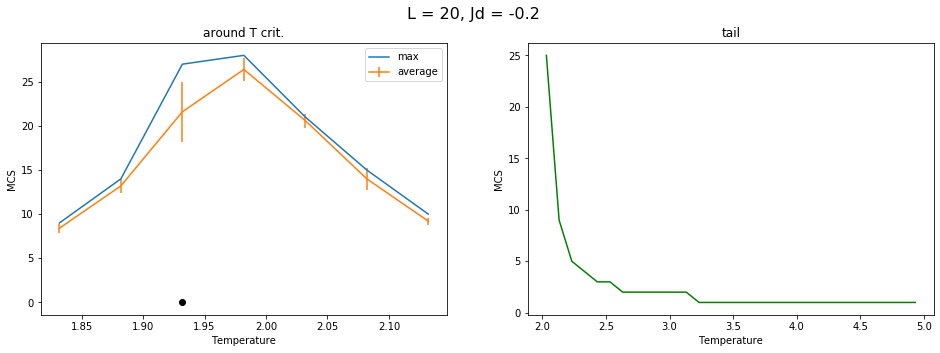

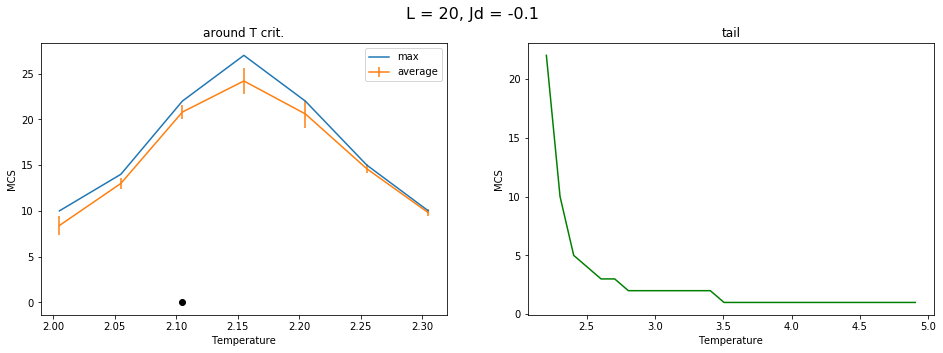

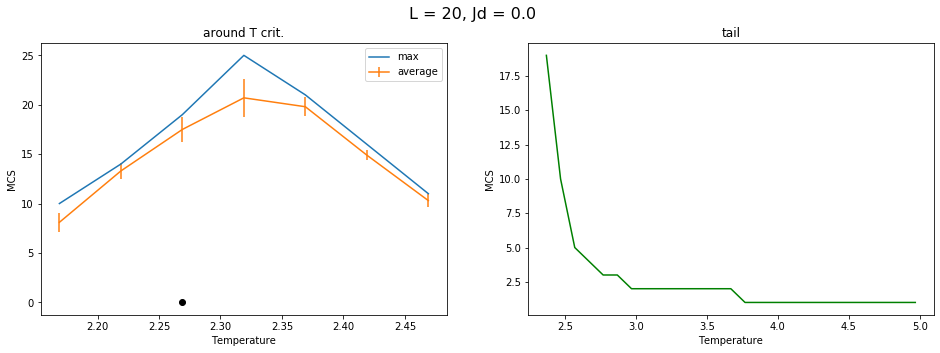

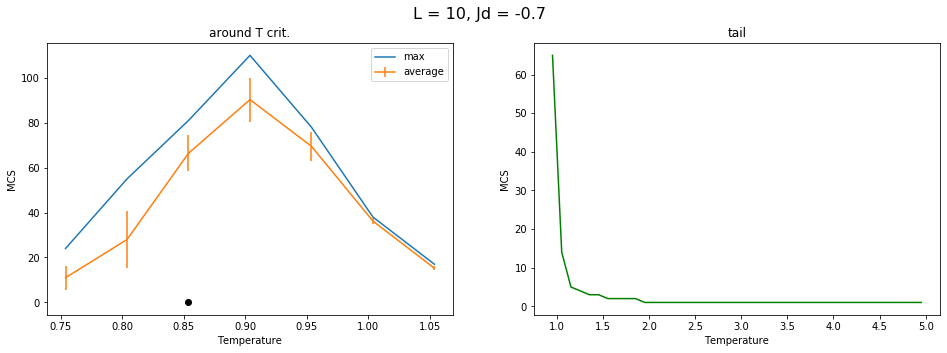

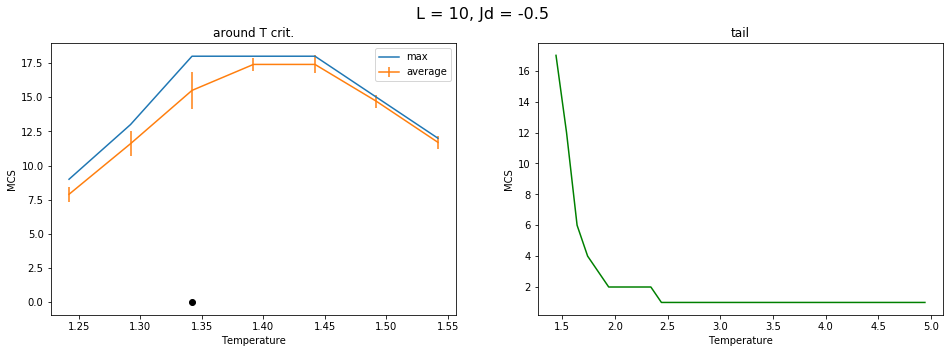

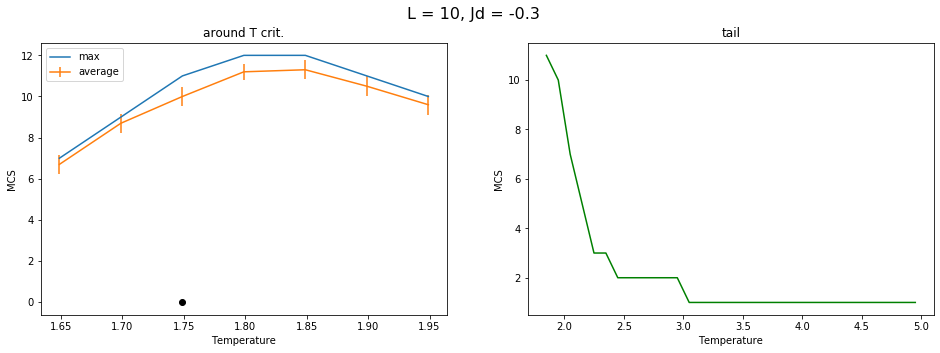

No handles with labels found to put in legend.


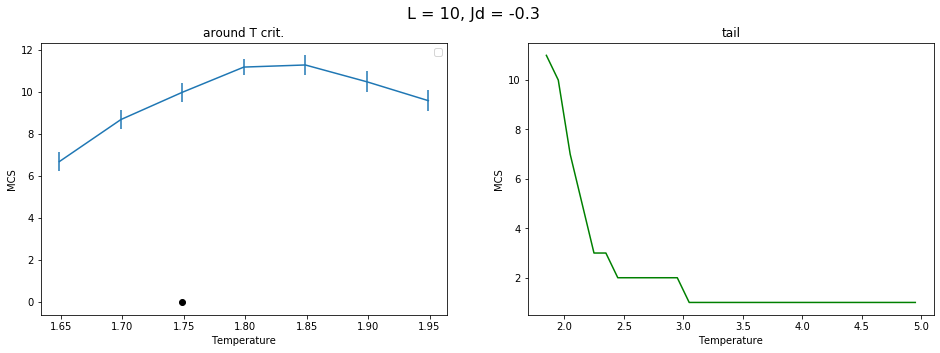

No handles with labels found to put in legend.


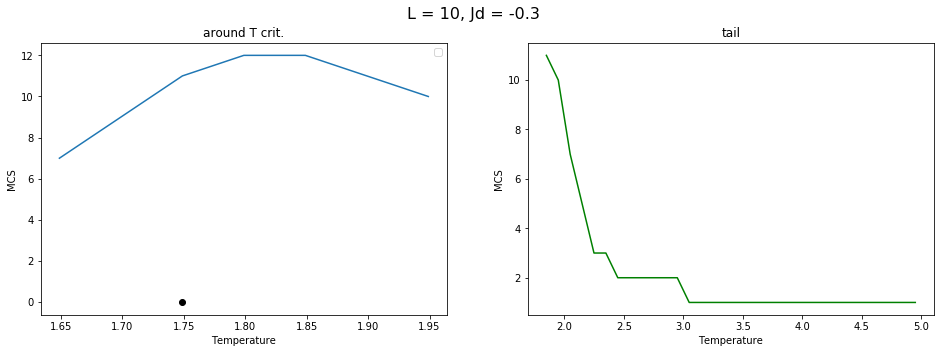

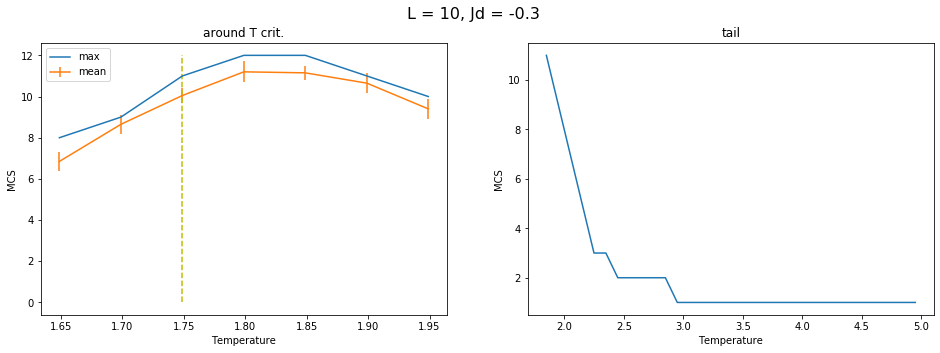

In [277]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))

ax1.plot([T_crit]*2, [0,np.max(MCS_max)], c  = 'y', linestyle = '--')
ax1.plot(Ts, MCS_max, label = 'max') 
ax1.errorbar(Ts, MCS_mean, yerr = error, label = 'mean') 
ax1.set_title('around T crit.')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('MCS')
ax1.legend()

ax2.plot(Ts_tail, MCS_tail) 
ax2.set_title('tail')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('MCS')

fig.suptitle(f'L = {L}, Jd = {Jd}', fontsize=16)
plt.show()